<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_stock_trading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog uses FinRL to reproduce the paper: Practical Deep Reinforcement Learning Approach for Stock Trading, Workshop on Challenges and Opportunities for AI in Financial Services, NeurIPS 2018.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

# Target Problem

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


## Environment Setup

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Cache Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

### Fetch Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [7]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



In [8]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df.shape

(105680, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


## Data Preprocessing
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

### Feature Engineering

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [16]:
processed.shape
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0


### Data display

In [17]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

In [18]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0
5,2000-01-03,CMCSA,16.145832,16.333332,15.062500,12.189544,2333700.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,12.189544,12.189544,12.189544,12.189544,12.189544,12.189544,0.0
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,40.118656,53076000.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,40.118656,40.118656,40.118656,40.118656,40.118656,40.118656,0.0
7,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115248,8402230.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,23.115248,23.115248,23.115248,23.115248,23.115248,23.115248,0.0
8,2000-01-03,HD,68.625000,69.187500,63.812500,42.563168,12030800.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,42.563168,42.563168,42.563168,42.563168,42.563168,42.563168,0.0
9,2000-01-03,INTC,41.632812,43.687500,41.625000,27.002798,57710200.0,0.0,0.0,0.925665,...,-66.666667,-66.666667,100.0,27.002798,27.002798,27.002798,27.002798,27.002798,27.002798,0.0


### Data Split

In [20]:
train = data_split(processed_full, start_date, split_date)
evaluate = data_split(processed_full, split_date, end_date)
print(len(train))
print(len(evaluate))

95580
10100


## RL Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [21]:
initialData = train.loc[0,:]
print(initialData)

         date    tic       open       high        low      close       volume  \
0  2000-01-03   AAPL   0.936384   1.004464   0.907924   0.859423  535796800.0   
0  2000-01-03   ADBE  16.812500  16.875000  16.062500  16.274673    7384400.0   
0  2000-01-03   AMZN  81.500000  89.562500  79.046875  89.375000   16117600.0   
0  2000-01-03    BAC  25.125000  25.125000  24.000000  13.952057   13705800.0   
0  2000-01-03  BRK-B  36.500000  36.580002  34.820000  35.299999     875000.0   
0  2000-01-03  CMCSA  16.145832  16.333332  15.062500  12.189544    2333700.0   
0  2000-01-03   CSCO  54.968750  55.125000  51.781250  40.118656   53076000.0   
0  2000-01-03    DIS  28.855125  29.533344  28.361876  23.115248    8402230.0   
0  2000-01-03     HD  68.625000  69.187500  63.812500  42.563168   12030800.0   
0  2000-01-03   INTC  41.632812  43.687500  41.625000  27.002798   57710200.0   
0  2000-01-03    JNJ  46.562500  46.875000  45.781250  26.811003    4642400.0   
0  2000-01-03    JPM  49.833

In [22]:
evaluate.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.439735,148158800.0,2.0,-2.013469,44.430054,...,5.338357,-62.506106,42.250808,39.907269,46.409359,48.900092,39.894455,44.458658,46.304234,40.714627
0,2019-01-02,ADBE,219.910004,226.169998,219.000000,224.570007,2784100.0,2.0,-5.282335,259.815658,...,42.283562,-46.078026,18.279805,231.481001,239.189334,249.605750,228.071064,238.013177,241.061149,40.714627
0,2019-01-02,AMZN,1465.199951,1553.359985,1460.930054,1539.130005,7983100.0,2.0,-46.142964,1783.043118,...,71.986956,-29.701621,16.053433,1558.427496,1640.886670,1772.662920,1531.028514,1632.326567,1675.234803,40.714627
0,2019-01-02,BAC,24.080000,25.139999,24.010000,23.649902,71836300.0,2.0,-0.669456,25.783587,...,82.345511,-11.196459,18.930726,23.473258,25.393073,27.097682,23.590685,25.158157,26.235524,40.714627
0,2019-01-02,BRK-B,201.729996,204.399994,201.149994,202.800003,4802100.0,2.0,-2.760708,215.345783,...,106.526697,18.020183,2.953389,201.200500,208.270668,208.078834,201.656593,206.289644,206.078162,40.714627


In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 321


In [25]:
env_params = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-6
}

e_train_gym = StockTradingEnv(df = train, **env_params)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.811002731323242, 25.863813400268555, 37.01738357543945, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.720722899

## Environment for Training



In [26]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.811002731323242, 25.863813400268555, 37.01738357543945, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.720722899

## RL Models Training: (A2C DDPG, PPO, TD3, SAC)
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Actor-Critic


In [30]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [33]:
trained_a2c = agent.train_model(
    model=model_a2c, 
    tb_log_name='a2c',
    total_timesteps=10000)

[1000000, 0.3190849721431732, 19.832889556884766, 53.470001220703125, 26.833345413208008, 55.34000015258789, 8.351469039916992, 17.634572982788086, 18.67784881591797, 23.304628372192383, 19.685203552246094, 31.22236442565918, 22.465547561645508, 17.43528938293457, 6.9667439460754395, 16.732027053833008, 30.199907302856445, 9.787001609802246, 23.725021362304688, 13.349738121032715, 23.026378631591797, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.005557896659567518, -0.20625962357374306, -0.17237410796204955, 0.35967923428182047, 0.2672124025217144, 0.007443455577277547, 0.2968291828602432, 0.21673051818122957, -0.15626179425707676, -0.2604521539047582, 0.07711752354884283, 0.10624872880069702, 0.17532587891749074, 0.15562602624531063, 0.1989233670895807, 0.1765727096497507, 0.2009476501688372, 0.472316665095466, 0.1436664767165894, 0.5183331273607905, 0.3346450153188923, 21.166966343631447, 55.14026909657093, 27.073584771092186, 56.426369113229434, 8.3943729728608, 18.

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 500      |
|    time_elapsed       | 21       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -32.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 699      |
|    policy_loss        | -1.58    |
|    std                | 1.24     |
|    value_loss         | 0.00278  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 600      |
|    time_elapsed       | 26       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -33.4    |
|    explained_variance | -0.337   |
|    learning_rate      | 0.0007   |
|    n_updates          | 799      |
|    policy_loss        | -0.74    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 5.22e+06 |
|    total_cost         | 7.61e+04 |
|    total_reward       | 4.22e+06 |
|    total_reward_pct   | 422      |
|    total_trades       | 68904    |
| time/                 |          |
|    fps                | 111      |
|    iterations         | 1000     |
|    time_elapsed       | 44       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1199     |
|    policy_loss        | -0.29    |
|    std                | 1.42     |
|    value_loss         | 6.27e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 1100     |
|    time_elapsed       | 49       |
|    total_timesteps    | 5500     |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.06e+06 |
|    total_cost         | 5.29e+04 |
|    total_reward       | 3.06e+06 |
|    total_reward_pct   | 306      |
|    total_trades       | 64383    |
| time/                 |          |
|    fps                | 108      |
|    iterations         | 2000     |
|    time_elapsed       | 92       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -40.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 2199     |
|    policy_loss        | 0.982    |
|    std                | 1.87     |
|    value_loss         | 0.000782 |
------------------------------------


### Deep Deterministic Policy Gradient

In [34]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [35]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=10000)

[1000000, 0.24568630754947662, 14.342045783996582, 6.909999847412109, 16.164615631103516, 48.70000076293945, 9.60822868347168, 10.833200454711914, 14.880112648010254, 24.895578384399414, 13.356536865234375, 33.035438537597656, 18.577688217163086, 17.3269100189209, 9.858832359313965, 18.92488670349121, 21.192428588867188, 16.550289154052734, 14.283258438110352, 19.804386138916016, 22.27162742614746, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.009467772413498637, -0.6338188893068679, -0.7325316637356751, -0.3434338716674574, 0.8144076821584179, 0.051689777917959034, -0.33650513143272676, -1.093945710044002, -1.0126303695574883, -0.9092031600717547, 0.14912734724902776, -0.8130073359699352, -0.2940400612119767, -0.6239170871142967, 0.24510026427537923, -0.05624077887487644, 0.3035985988726928, 0.1456615023974024, 0.29336074842936455, 0.045593243931143945, 0.2720366713085709, 16.612265683025985, 8.6559894236633, 19.07677443452, 50.40122929815526, 9.92850744212864, 11.692

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 121.43285369873047, 90.1629638671875, 98.81327819824219, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.102228793422313, -2.889179649527293, -1.989642958275212, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.44073

### Model 3: PPO

In [36]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [37]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=10000)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.811002731323242, 25.863813400268555, 37.01738357543945, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.720722899

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.06e+06    |
|    total_cost           | 2.74e+05    |
|    total_reward         | 3.06e+06    |
|    total_reward_pct     | 306         |
|    total_trades         | 93342       |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 47          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.014766663 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -28.4       |
|    explained_variance   | -2.54       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.308      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0268     |
|    std                  | 1           |
|    value_loss           | 0.0283

### Model 4: TD3

In [38]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [39]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=10000)

[1000000, 0.22802820801734924, 9.419783592224121, 16.049999237060547, 20.521154403686523, 47.119998931884766, 5.871837615966797, 8.880401611328125, 11.865073204040527, 19.746742248535156, 8.827279090881348, 31.90957260131836, 11.183682441711426, 14.363935470581055, 2.6990771293640137, 13.482650756835938, 27.238399505615234, 8.231143951416016, 18.84564208984375, 11.092745780944824, 18.177989959716797, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0025233269674986847, -0.18533166915073807, 0.4824205579245415, -0.24468304185339207, 0.09599973072943158, 0.04607760598161903, -0.30628487278888095, -0.1704489047824822, 0.07939348229163556, -0.5077475285962727, -0.11154675176247508, -0.9273462572920206, -0.22901921805982361, -0.23665699470199808, -0.4333629162584369, 0.1969359234117647, -0.32614323589510086, 0.13472191671457878, -0.1705423092009628, -0.4077994507971283, 0.23493472237949192, 10.550543141565694, 18.17389555815258, 23.21789159634027, 51.1274945903109, 6.790797266

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 121.43285369873047, 90.1629638671875, 98.81327819824219, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.102228793422313, -2.889179649527293, -1.989642958275212, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.44073

### Model 5: SAC

In [40]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [41]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=10000)

[1000000, 0.859423041343689, 16.274673461914062, 89.375, 13.952056884765625, 35.29999923706055, 12.189543724060059, 40.118656158447266, 23.11524772644043, 42.563167572021484, 27.002798080444336, 26.811002731323242, 25.863813400268555, 37.01738357543945, 3.585430383682251, 14.565584182739258, 30.248369216918945, 15.941187858581543, 5.632353782653809, 20.573511123657227, 20.461938858032227, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.925665153969376, 0.720722899924667, 0.720722899924667, 0.720722899924667, 0.720722899

[1000000, 38.39591979980469, 226.24000549316406, 1501.969970703125, 23.346698760986328, 204.17999267578125, 32.51496124267578, 40.123985290527344, 108.32612609863281, 162.39141845703125, 44.13541793823242, 121.43285369873047, 90.1629638671875, 98.81327819824219, 132.7157745361328, 37.58075714111328, 86.1761703491211, 24.279356002807617, 240.15750122070312, 50.585201263427734, 58.40364074707031, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.141041777965299, -5.676368887152876, -53.443770397858316, -0.7670631267137757, -3.2557177528346415, -0.8954391581344154, -0.9799449674846201, -1.8656878145195321, -2.2328399684980695, -0.32983955379442875, -4.102228793422313, -2.889179649527293, -1.989642958275212, -12.202282769826184, -0.31164924659512394, -0.15894413380489425, -0.5432299344854066, -6.482025623390342, -0.7203707316276251, -2.482863766377193, 44.89222937062556, 262.20470153717605, 1797.9009431978748, 26.367951753238582, 218.04005191465728, 37.59954298378438, 46.44073

## Evaluation
Initial portfolio as $1,000,000 at 2019-01-01. Apply selected model to trade above stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile.

In [42]:
data_turbulence = processed_full[(processed_full.date<'2019-01-01') & (processed_full.date>='2000-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [43]:
insample_turbulence.turbulence.describe()

count    4779.000000
mean       21.934472
std        24.863759
min         0.000000
25%         9.761904
50%        15.566416
75%        25.548274
max       368.332467
Name: turbulence, dtype: float64

In [44]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [45]:
turbulence_threshold

368.3324669209491

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [47]:
trade = data_split(processed_full, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = turbulence_threshold * 10, **env_params)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

[1000000, 38.439735412597656, 224.57000732421875, 1539.1300048828125, 23.64990234375, 202.8000030517578, 32.8205451965332, 39.7721061706543, 107.65434265136719, 162.94903564453125, 44.27648162841797, 120.20957946777344, 91.72384643554688, 98.37548065185547, 135.4197998046875, 37.23637771606445, 85.57616424560547, 25.13007164001465, 234.7300567626953, 50.405242919921875, 59.68837356567383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.01346910769135, -5.282335098980269, -46.1429635502293, -0.6694559492340382, -2.7607079026378756, -0.856741191421797, -0.9455581149819992, -1.651912931269365, -1.7997391293691862, -0.2572228966760548, -4.013110074480451, -2.5660852949502413, -1.9043699674799228, -11.400488733808174, -0.26204783597102477, -0.17511634955393163, -0.45399530891330997, -6.5089857720333555, -0.6448272151559422, -2.3416385499996792, 44.43005367394433, 259.81565839606503, 1783.0431178984259, 25.783587106491655, 215.34578294632635, 37.16959442554747, 46.120800952883

In [48]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2019-01-02,AAPL,38.722500,39.712502,38.557499,38.439735,148158800.0,2.0,-2.013469,44.430054,...,5.338357,-62.506106,42.250808,39.907269,46.409359,48.900092,39.894455,44.458658,46.304234,40.714627
0,2019-01-02,ADBE,219.910004,226.169998,219.000000,224.570007,2784100.0,2.0,-5.282335,259.815658,...,42.283562,-46.078026,18.279805,231.481001,239.189334,249.605750,228.071064,238.013177,241.061149,40.714627
0,2019-01-02,AMZN,1465.199951,1553.359985,1460.930054,1539.130005,7983100.0,2.0,-46.142964,1783.043118,...,71.986956,-29.701621,16.053433,1558.427496,1640.886670,1772.662920,1531.028514,1632.326567,1675.234803,40.714627
0,2019-01-02,BAC,24.080000,25.139999,24.010000,23.649902,71836300.0,2.0,-0.669456,25.783587,...,82.345511,-11.196459,18.930726,23.473258,25.393073,27.097682,23.590685,25.158157,26.235524,40.714627
0,2019-01-02,BRK-B,201.729996,204.399994,201.149994,202.800003,4802100.0,2.0,-2.760708,215.345783,...,106.526697,18.020183,2.953389,201.200500,208.270668,208.078834,201.656593,206.289644,206.078162,40.714627


In [55]:
def prediction(model, environment):
    return DRLAgent.DRL_prediction(
    model=model, 
    environment = environment)
df_value, df_actions = dict(), dict()
df_value['a2c'], df_actions['a2c'] = prediction(trained_a2c, e_trade_gym)
df_value['ddpg'], df_actions['ddpg'] = prediction(trained_ddpg, e_trade_gym)
df_value['ppo'], df_actions['ppo'] = prediction(trained_ppo, e_trade_gym)
df_value['td3'], df_actions['td3'] = prediction(trained_td3, e_trade_gym)
df_value['sac'], df_actions['sac'] = prediction(trained_sac, e_trade_gym)

[1000000, 38.439735412597656, 224.57000732421875, 1539.1300048828125, 23.64990234375, 202.8000030517578, 32.8205451965332, 39.7721061706543, 107.65434265136719, 162.94903564453125, 44.27648162841797, 120.20957946777344, 91.72384643554688, 98.37548065185547, 135.4197998046875, 37.23637771606445, 85.57616424560547, 25.13007164001465, 234.7300567626953, 50.405242919921875, 59.68837356567383, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2.01346910769135, -5.282335098980269, -46.1429635502293, -0.6694559492340382, -2.7607079026378756, -0.856741191421797, -0.9455581149819992, -1.651912931269365, -1.7997391293691862, -0.2572228966760548, -4.013110074480451, -2.5660852949502413, -1.9043699674799228, -11.400488733808174, -0.26204783597102477, -0.17511634955393163, -0.45399530891330997, -6.5089857720333555, -0.6448272151559422, -2.3416385499996792, 44.43005367394433, 259.81565839606503, 1783.0431178984259, 25.783587106491655, 215.34578294632635, 37.16959442554747, 46.120800952883

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 156.4047088623047, 125.42272186279297, 221.90890502929688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.211265218575562, 2.755051524216597, 2.5596409289634323, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 156.4047088623047, 125.42272186279297, 221.90890502929688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.211265218575562, 2.755051524216597, 2.5596409289634323, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 156.4047088623047, 125.42272186279297, 221.90890502929688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.211265218575562, 2.755051524216597, 2.5596409289634323, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

day: 504, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1438984.92
total_reward: 438984.92
total_cost: 1074.90
total_trades: 4044
Sharpe: 0.786
[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 156.4047088623047, 125.42272186279297, 221.90890502929688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.211265218575562, 2.755051524216597, 2.5596409289634323, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7

[1000000, 132.26734924316406, 500.1199951171875, 3256.929931640625, 30.16019630432129, 231.8699951171875, 51.92343521118164, 44.07402801513672, 181.17999267578125, 263.96588134765625, 49.21628952026367, 156.4047088623047, 125.42272186279297, 221.90890502929688, 522.0198364257812, 36.05856704711914, 137.426513671875, 27.784883499145508, 349.43853759765625, 57.509002685546875, 39.9496955871582, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.8535854042010413, 6.205609911835893, 28.614195425351227, 0.7280440205133729, 1.2291085225896836, 0.5796021474586865, 0.7341816780368688, 8.849684867275954, -1.1098969575164688, 0.028844635174799294, 2.211265218575562, 2.755051524216597, 2.5596409289634323, -3.050795866366684, -0.2622567906135984, -0.16889812725571574, -0.12426313325140725, 2.021413399247706, -0.4053104425782337, 0.7209080106379417, 136.906108108328, 509.84833735584766, 3316.952411159271, 30.368344106625475, 233.09211129831115, 51.90307064089121, 44.5135974519387, 188.89

In [56]:
df_value['a2c'].tail()

,date,account_value
500,2020-12-24,1.163367e+06
501,2020-12-28,1.175852e+06
502,2020-12-29,1.175747e+06
503,2020-12-30,1.172547e+06
504,2020-12-31,1.182293e+06


In [58]:
df_actions['a2c'].head()

,AAPL,ADBE,AMZN,BAC,BRK-B,CMCSA,CSCO,DIS,HD,INTC,JNJ,JPM,MSFT,NVDA,PFE,PG,T,UNH,VZ,XOM
date,,,,,,,,,,,,,,,,,,,,
2019-01-02,0,0,100,0,36,100,60,100,0,46,0,100,34,41,30,100,0,100,100,100
2019-01-03,37,32,-100,100,-36,100,100,-100,0,-46,100,-63,-34,0,-30,21,0,100,-62,100
2019-01-04,-37,-32,100,100,0,5,66,0,0,0,100,-22,100,-41,0,-46,0,100,80,100
2019-01-07,0,72,100,-48,0,100,100,0,0,0,27,-7,-39,100,0,19,100,100,75,-64
2019-01-08,100,100,34,21,100,74,100,100,0,100,14,-8,-61,100,100,26,28,79,100,99


### Evaluation
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [60]:
model_name_list=['a2c','ddpg','ppo','td3','sac']

In [68]:
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

def backtest(df_value, model_name):
    print("\n{} performance backtest:\n".format(model_name))
    perf_stats = backtest_stats(account_value=df_value)
    perf_stats = pd.DataFrame(perf_stats)
    perf_stats.to_csv("./"+config.RESULTS_DIR+"/perf_stats_"+model_name+"_"+now+'.csv')
    return perf_stats

perf_stats_all = dict()
for model_name in model_name_list:
    perf_stats = backtest(df_value[model_name], model_name)
    perf_stats_all[model_name] = perf_stats


a2c performance backtest:

Annual return          0.087153
Cumulative returns     0.182293
Annual volatility      0.335920
Sharpe ratio           0.418237
Calmar ratio           0.224524
Stability              0.125553
Max drawdown          -0.388168
Omega ratio            1.089722
Sortino ratio          0.595738
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.991156
Daily value at risk   -0.041764
dtype: float64

ddpg performance backtest:

Annual return          0.433536
Cumulative returns     1.057964
Annual volatility      0.292633
Sharpe ratio           1.380355
Calmar ratio           1.710529
Stability              0.840296
Max drawdown          -0.253451
Omega ratio            1.288143
Sortino ratio          2.016821
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933800
Daily value at risk   -0.035265
dtype: float64

ppo performance backtest:

Annual return          0.144257
Cumulative returns   

In [70]:
#baseline stats
print("baseline performance backtest:")
baseline_df = get_baseline(
        ticker="SPY", 
        start = split_date,
        end = end_date)

stats = backtest_stats(baseline_df, value_col_name = 'close')

baseline performance backtest:
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.244922
Cumulative returns     0.551180
Annual volatility      0.252380
Sharpe ratio           0.997196
Calmar ratio           0.726401
Stability              0.604514
Max drawdown          -0.337173
Omega ratio            1.234938
Sortino ratio          1.372114
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.738843
Daily value at risk   -0.030798
dtype: float64


### BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,66.428%
Cumulative returns,177.545%
Annual volatility,39.226%
Sharpe ratio,1.50
Calmar ratio,1.92
Stability,0.90
Max drawdown,-34.645%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.65,2020-02-19,2020-03-16,2020-05-15,63
1,15.37,2020-09-02,2020-09-08,NaT,NaN
2,14.52,2019-04-08,2019-06-03,2019-07-12,70
3,10.90,2019-07-24,2019-08-15,2019-09-11,36
4,5.72,2020-06-10,2020-06-11,2020-06-22,9


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.23%,-16.78%,14.43%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


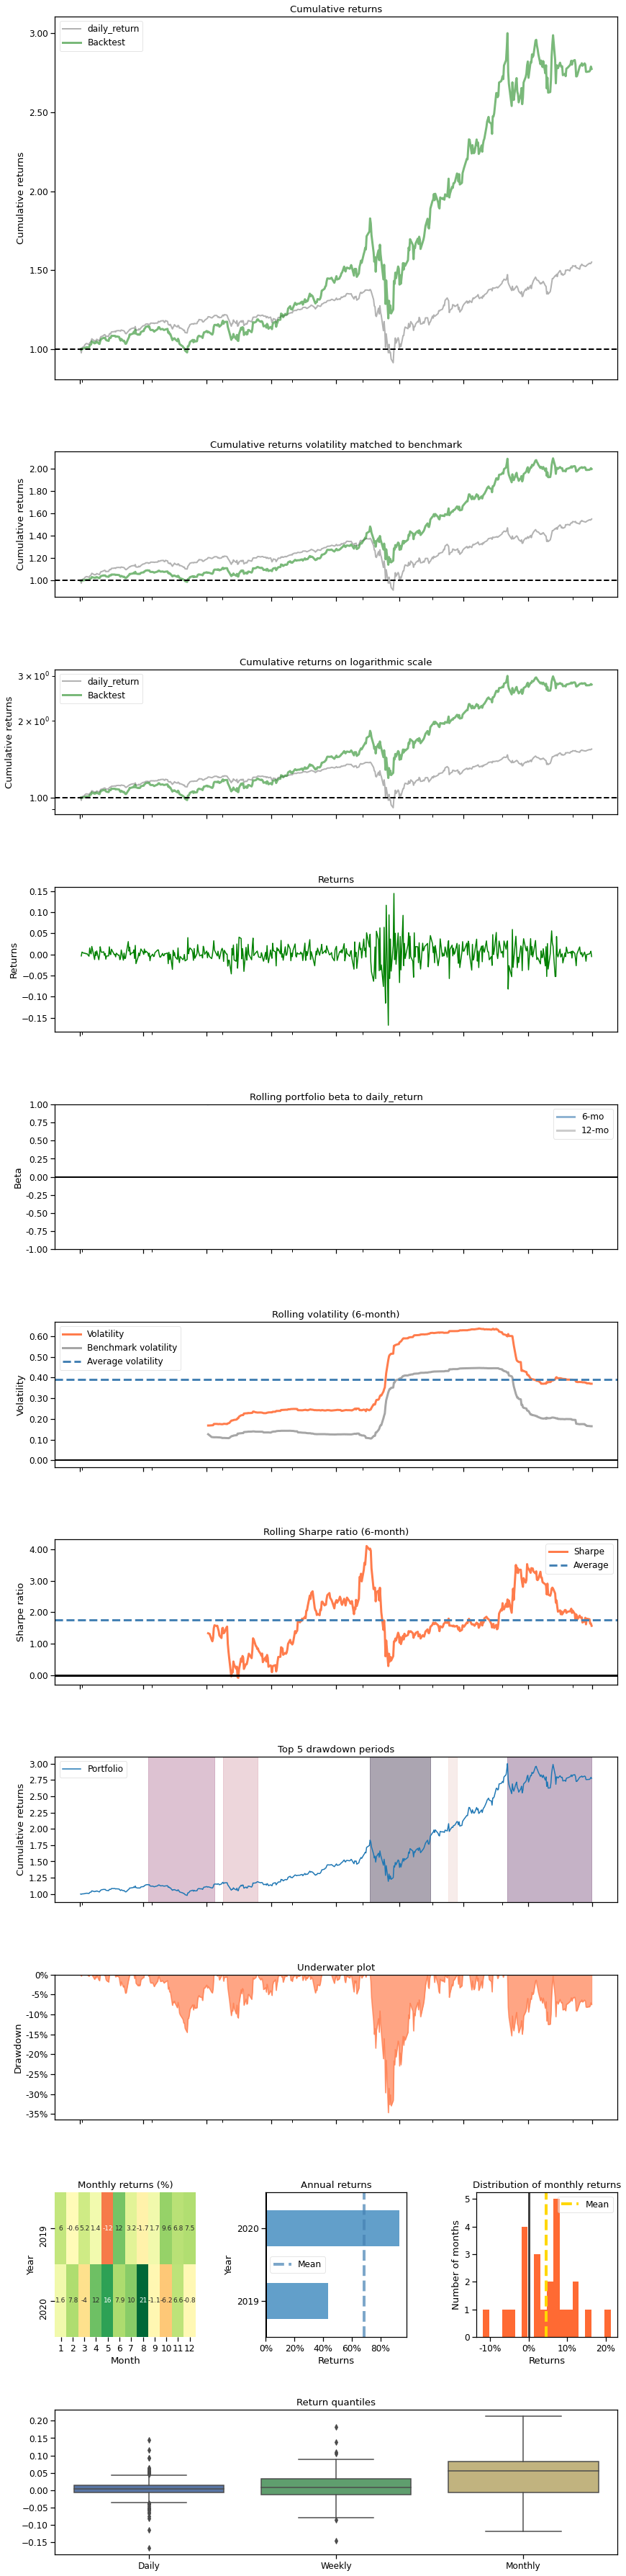

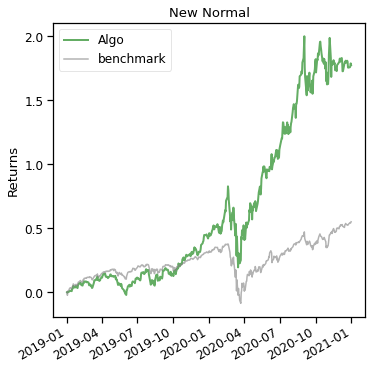

In [74]:
print("==============Compare to SPY===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_value['sac'], 
             baseline_ticker = 'SPY', 
             baseline_start = split_date,
             baseline_end = end_date)